Analyze 13/97-106 (0.3 nm radius, 1600 K with 20 windows) except 12/103-104 uses 0.4 nm radius

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    

## D39A, A39D

In [3]:
# Load data into dicts and plot 
titles = ["D39A", "A39D"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 13
forward = 97
reverse = 98
for i in tqdm_notebook([forward, reverse]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

dir: 97
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 250001)
job: 40
(1, 250001)
job: 41
(1, 250001)
job: 42
(1, 250001)
job: 43
(1, 250001)
job: 44
(1, 250001)
job: 45
(1, 250001)
job: 46
(1, 250001)
job: 47
(1, 250001)
job: 48
(1, 250001)
job: 49
(1, 250001)
jo

plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/97/97_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/97/97_apo_work_dist.png
dir: 98
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 250001)
jo

saved to: /data/chodera/zhangi/perses_benchmark/neq/13/98/98_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/98/98_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/98/98_apo_work_dist.png



<Figure size 432x288 with 0 Axes>

In [4]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward, reverse]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


<AxesSubplot:ylabel='Density'>

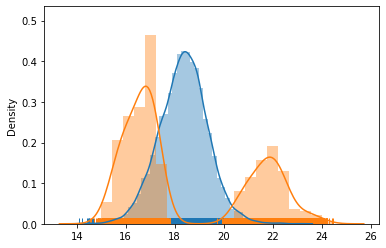

In [5]:
# Plot ddgs
sns.distplot(ddgs[forward], rug=True, label=titles[0])
sns.distplot(np.array(ddgs[reverse])*-1, rug=True, label=titles[1])

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
reverse_ddg = np.mean(ddgs[reverse])
reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

In [7]:
output_kcalmol

[10.94, (9.77, 12.11), -10.97, (-13.81, -9.2), (0.57, -1.7)]

In [8]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

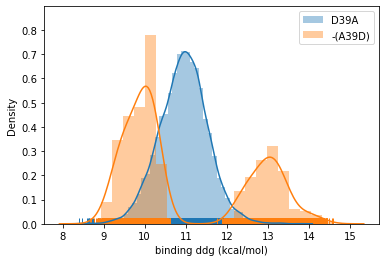

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## K27A, A27K

In [11]:
# Load data into dicts and plot 
titles = ["K27A", "A27K"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 13
forward = 99
reverse = 100
for i in tqdm_notebook([forward, reverse]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

dir: 99
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 250001)
job: 40
(1, 250001)
job: 41
(1, 250001)
job: 42
(1, 250001)
job: 43
(1, 250001)
job: 44
(1, 250001)
job: 45
(1, 250001)
job: 46
(1, 250001)
job: 47
(1, 250001)
job: 48
(1, 250001)
job: 49
(1, 250001)
jo

plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/99/99_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/99/99_apo_work_dist.png
dir: 100
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 250001)
j

saved to: /data/chodera/zhangi/perses_benchmark/neq/13/100/100_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/100/100_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/100/100_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/100/100_apo_work_dist.png



<Figure size 432x288 with 0 Axes>

In [12]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward, reverse]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


In [13]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
reverse_ddg = np.mean(ddgs[reverse])
reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

In [14]:
output_kcalmol

[7.07, (6.69, 7.43), -8.88, (-9.5, -8.28), (-1.6, -2.07)]

In [15]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [16]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

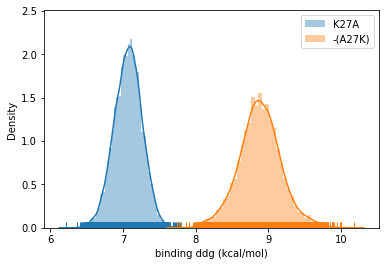

In [17]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## R59A, A59R

In [45]:
# Load data into dicts and plot 
titles = ["R59A", "A59R"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 13
forward = 101
reverse = 102
for i in tqdm_notebook([forward, reverse]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

dir: 101
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 250001)
job: 40
(1, 250001)
job: 41
(1, 250001)
job: 42
(1, 250001)
job: 43
(1, 250001)
job: 44
(1, 250001)
job: 45
(1, 250001)
job: 46
(1, 250001)
job: 47
(1, 250001)
job: 48
(1, 250001)
job: 49
(1, 250001)
j

plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/101/101_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/101/101_apo_work_dist.png
dir: 102
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 25000

saved to: /data/chodera/zhangi/perses_benchmark/neq/13/102/102_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/102/102_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/102/102_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/102/102_apo_work_dist.png



<Figure size 432x288 with 0 Axes>

In [46]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward, reverse]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


In [47]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
reverse_ddg = np.mean(ddgs[reverse])
reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

In [48]:
output_kcalmol

[4.96, (4.29, 5.56), -2.4, (-2.77, -2.03), (2.27, 2.79)]

In [49]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [50]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

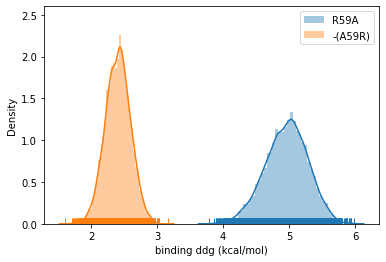

In [51]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

# R83Q, Q83R

In [25]:
# Load data into dicts and plot 
titles = ["R83Q", "Q83R"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 13
forward = 103
reverse = 104
for i in tqdm_notebook([forward, reverse]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
                        print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

dir: 103
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 250001)
job: 40
(1, 250001)
job: 41
(1, 250001)
job: 42
(1, 250001)
job: 43
(1, 250001)
job: 44
(1, 250001)
job: 45
(1, 250001)
job: 46
(1, 250001)
job: 47
(1, 250001)
job: 48
(1, 250001)
job: 49
(1, 250001)
j

plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/103/103_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/103/103_apo_work_dist.png
dir: 104
job: 0
(1, 250001)
job: 1
(1, 250001)
job: 2
(1, 250001)
job: 3
(1, 250001)
job: 4
(1, 250001)
job: 5
(1, 250001)
job: 6
(1, 250001)
job: 7
(1, 250001)
job: 8
(1, 250001)
job: 9
(1, 250001)
job: 10
(1, 250001)
job: 11
(1, 250001)
job: 12
(1, 250001)
job: 13
(1, 250001)
job: 14
(1, 250001)
job: 15
(1, 250001)
job: 16
(1, 250001)
job: 17
(1, 250001)
job: 18
(1, 250001)
job: 19
(1, 250001)
job: 20
(1, 250001)
job: 21
(1, 250001)
job: 22
(1, 250001)
job: 23
(1, 250001)
job: 24
(1, 250001)
job: 25
(1, 250001)
job: 26
(1, 250001)
job: 27
(1, 250001)
job: 28
(1, 250001)
job: 29
(1, 250001)
job: 30
(1, 250001)
job: 31
(1, 250001)
job: 32
(1, 250001)
job: 33
(1, 250001)
job: 34
(1, 250001)
job: 35
(1, 250001)
job: 36
(1, 250001)
job: 37
(1, 250001)
job: 38
(1, 250001)
job: 39
(1, 25000

saved to: /data/chodera/zhangi/perses_benchmark/neq/13/104/104_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/104/104_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/104/104_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/104/104_apo_work_dist.png



<Figure size 432x288 with 0 Axes>

In [26]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward, reverse]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


In [27]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
reverse_ddg = np.mean(ddgs[reverse])
reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

In [28]:
output_kcalmol

[5.49, (2.96, 8.32), -19.62, (-21.2, -16.53), (-13.57, -12.87)]

In [29]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [30]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

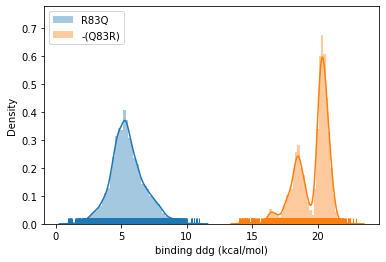

In [31]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## R87A, A87R

In [32]:
# Load data into dicts and plot 
titles = ["R87A", "A87R"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 13
forward = 105
reverse = 106
# for i in tqdm_notebook([forward]):
for i in tqdm_notebook([forward, reverse]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
#                 print(f"job: {j}")
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                if os.path.exists(path):
                    with open(path, 'rb') as f:
                        array = np.load(f)
                        all_arrays.append(array)
#                         print(array.shape)
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
                combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

dir: 105
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/105/105_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/105/105_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/105/105_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/105/105_apo_work_dist.png
dir: 106
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/106/106_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/106/106_complex_work_dist.png
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/106/106_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/13/106/106_apo_work_dist.png



<Figure size 432x288 with 0 Axes>

subtracting offset
plotting work distrib


Text(0, 0.5, 'p(w)')

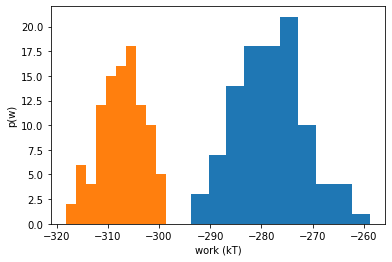

In [33]:
forward_work = d_combined_works['apo']['forward']
reverse_work = d_combined_works['apo']['reverse']

# Substract offset
print("subtracting offset")
forward_work_offset = []
for cycle in forward_work:
    forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset = np.array(forward_work_offset)

reverse_work_offset = []
for cycle in reverse_work:
    reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
reverse_work_offset = np.array(reverse_work_offset)

# Plot work distributions
print("plotting work distrib")
accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
plt.hist(accumulated_forward)
plt.hist(accumulated_reverse)
# plt.axvline(dg)
# plt.axvline(dg + ddg, linestyle='dashed')
# plt.axvline(dg - ddg, linestyle='dashed')
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
# plt.title(f"{title} {phase}")
# plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
# print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
# plt.clf()

In [34]:
max(accumulated_reverse)

-298.6519755893753

In [35]:
min(accumulated_forward)

-293.8469877725697

plotting work trajs


Text(0, 0.5, 'work (kT)')

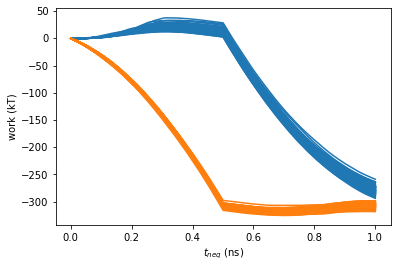

In [36]:
# Plot work trajectories
print("plotting work trajs")
for cycle in forward_work_offset:
    x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
    y = cycle
    plt.plot(x, y, color=sns.color_palette()[0])
for cycle in reverse_work_offset:
    x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
    y = -cycle
    plt.plot(x, y, color=sns.color_palette()[1])
plt.xlabel("$t_{neq}$ (ns)")
plt.ylabel("work (kT)")
# plt.title(f"{title} {phase}")
# plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
# print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
# plt.clf()

In [37]:
max([-cycle[-1] for cycle in reverse_work_offset])

-298.6519755893753

In [38]:
min([cycle[-1] for cycle in forward_work_offset])

-293.8469877725697

In [39]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward, reverse]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


In [40]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
reverse_ddg = np.mean(ddgs[reverse])
reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

In [41]:
output_kcalmol

[17.22, (16.27, 17.92), -16.98, (-18.14, -16.01), (0.25, -0.22)]

In [42]:
pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [43]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

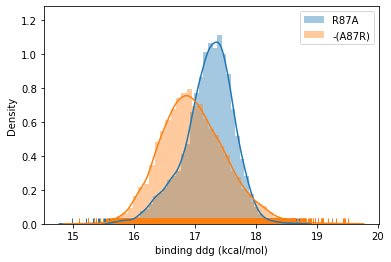

In [44]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## Plot all ddgs

In [48]:
# title_pairs = [["T42A", "A42T"], ["Y29A", "A29Y"], ["W38F", "F38W"], ["W44F", "F44W"], ["Y29F", "F29Y"]]
# title_pairs = [["T42A", "-(A42T)"], ["Y29A", "-(A29Y)"], ["W44F", "-(F44W)"], ["Y29F", "-(F29Y)"]]
title_pairs = [["D35A", "-(A35D)"], ["D39A", "-(A39D)"], ["E76A", "A76E"], ["E80A", "A80E"], ["K27A", "-(A27K)"], ["R59A", "-(A59R)"], ["R83Q", "-(Q83R)"], ["R87A", "-(A87R)"]]
dir_num = 13
# subdirs = [6, 40, 42, 44, 46]
# subdirs = [6, 40, 44, 46]
subdirs = list(range(48, 64, 2))
to_plot = np.zeros(shape=(len(np.array(title_pairs).flatten()), 3))
for i, subdir in enumerate(subdirs):
    with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{subdir}/ddgs.pickle", "rb") as f:
        ddgs = pickle.load(f)
        to_plot[i*2] = np.array([np.mean(ddgs[subdir])*KT_KCALMOL, np.mean(ddgs[subdir])*KT_KCALMOL - np.percentile(ddgs[subdir], 2.5)*KT_KCALMOL , np.percentile(ddgs[subdir], 97.5)*KT_KCALMOL - np.mean(ddgs[subdir])*KT_KCALMOL])
        to_plot[(i*2)+1] = np.array([np.mean(ddgs[subdir+1])*-KT_KCALMOL, np.mean(ddgs[subdir+1])*KT_KCALMOL*-1 - np.percentile(ddgs[subdir+1], 2.5)*-KT_KCALMOL, np.percentile(ddgs[subdir+1], 97.5)*-KT_KCALMOL - np.mean(ddgs[subdir+1])*KT_KCALMOL*-1]) # take the negative of these so they match the forward transform values

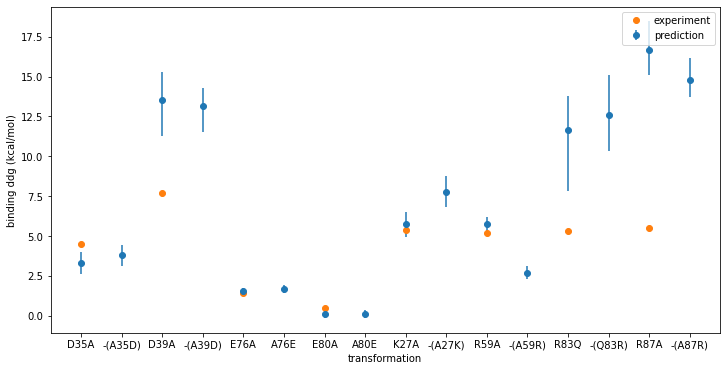

In [63]:
plt.errorbar(list(range(to_plot.shape[0])), to_plot[:,0], yerr=np.transpose(to_plot[:,1:]), ls='none', marker='o', label='prediction')
# exp = [1.8, 3.4, 1.6, 0.0, -0.1]
# exp = [1.8, 3.4, 0.0, -0.1]
exp = [4.5, 7.7, 1.4, 0.5, 5.4, 5.2, 5.3, 5.5]
plt.plot(list(range(0, to_plot.shape[0], 2)), exp, ls='none', marker='o', label='experiment')
plt.ylabel("binding ddg (kcal/mol)")
plt.xlabel("transformation")
plt.xticks(range(to_plot.shape[0]), np.array(title_pairs).flatten())
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.savefig(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/ddg_vs_transform_with_cis_charge.png", dpi=400)

## Get RMSE

In [64]:
# title_pairs = [["T42A", "A42T"], ["Y29A", "A29Y"], ["W38F", "F38W"], ["W44F", "F44W"], ["Y29F", "F29Y"]]
# title_pairs = [["T42A", "-(A42T)"], ["Y29A", "-(A29Y)"], ["W44F", "-(F44W)"], ["Y29F", "-(F29Y)"]]
title_pairs = [["D35A", "-(A35D)"], ["D39A", "-(A39D)"], ["E76A", "A76E"], ["E80A", "A80E"], ["K27A", "-(A27K)"], ["R59A", "-(A59R)"], ["R83Q", "-(Q83R)"], ["R87A", "-(A87R)"]]
dir_num = 13
# subdirs = [6, 40, 42, 44, 46]
subdirs = list(range(48, 64, 2))
ddgs_forward = np.zeros(shape=(len(subdirs), 10000))
ddgs_reverse = np.zeros(shape=(len(subdirs), 10000))
for i, subdir in enumerate(subdirs):
    with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{subdir}/ddgs.pickle", "rb") as f:
        ddgs = pickle.load(f)
        ddgs_kcalmol = np.array(ddgs[subdir])*KT_KCALMOL
        ddgs_forward[i] = ddgs_kcalmol
        ddgs_kcalmol = np.array(ddgs[subdir+1])*KT_KCALMOL
        ddgs_reverse[i] = ddgs_kcalmol
        

In [65]:
# exp = [1.8, 3.4, 0.0, -0.1]
exp = [4.5, 7.7, 1.4, 0.5, 5.4, 5.2, 5.3, 5.5]

In [66]:
from sklearn.metrics import mean_squared_error

rmses_forward = []
rmses_reverse = []
for i in range(10000):
    rmses_forward.append(mean_squared_error(exp, ddgs_forward[:,i], squared=False))
    rmses_reverse.append(mean_squared_error(np.array(exp)*-1, ddgs_reverse[:,i], squared=False))

In [67]:
forward_rmse = round(np.mean(rmses_forward), 2)
forward_rmse_ci = round(np.percentile(rmses_forward, 2.5), 2), round(np.percentile(rmses_forward, 97.5), 2)
reverse_rmse = round(np.mean(rmses_reverse), 2)
reverse_rmse_ci = round(np.percentile(rmses_reverse, 2.5), 2), round(np.percentile(rmses_reverse, 97.5), 2)

In [68]:
[forward_rmse, forward_rmse_ci]

[5.06, (4.26, 5.75)]

In [69]:
[reverse_rmse, reverse_rmse_ci]

[4.8, (4.23, 5.44)]

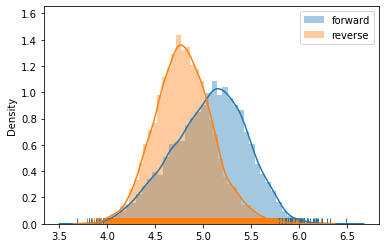

In [70]:
# Plot ddgs
sns.distplot(rmses_forward, rug=True, label="forward")
sns.distplot(rmses_reverse, rug=True, label="reverse")
plt.legend()

In [71]:
from sklearn.metrics import r2_score
r2_forward = []
r2_reverse = []
for i in range(10000):
    r2_forward.append(r2_score(exp, ddgs_forward[:,i]))
    r2_reverse.append(r2_score(np.array(exp)*-1, ddgs_reverse[:,i]))

In [72]:
forward_r2 = round(np.mean(r2_forward), 2)
forward_r2_ci = round(np.percentile(r2_forward, 2.5), 2), round(np.percentile(r2_forward, 97.5), 2)
reverse_r2 = round(np.mean(r2_reverse), 2)
reverse_r2_ci = round(np.percentile(r2_reverse, 2.5), 2), round(np.percentile(r2_reverse, 97.5), 2)

In [73]:
[forward_r2, forward_r2_ci]

[-4.32, (-5.83, -2.75)]

In [74]:
[reverse_r2, reverse_r2_ci]

[-3.77, (-5.11, -2.69)]

## Compute phase discrepancies

In [27]:
dir_num = 13
forward = 6
reverse = 7
titles= ["T42A", "A42T"]
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)

In [28]:
phases = ['apo', 'complex']
outputs_all = []
for phase in phases:
    forward_dgs = [d[phase][0] for d in dgs_phase[forward]]
    forward_dg = np.mean(forward_dgs)
    forward_ci = np.percentile(forward_dgs, 2.5), np.percentile(forward_dgs, 97.5)
    reverse_dgs = [d[phase][0] for d in dgs_phase[reverse]]
    reverse_dg = np.mean(reverse_dgs)
    reverse_ci = np.percentile(reverse_dgs, 2.5), np.percentile(reverse_dgs, 97.5)
    negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
    discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
    output_kt = [forward_dg, forward_ci, reverse_dg, reverse_ci, discrepancy]
    output_kcalmol = [round(forward_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_dg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]
    outputs_all.append(output_kcalmol)
    
    # Plot ddgs
    sns.distplot(np.array(forward_dgs)*KT_KCALMOL, rug=True, label=f"{titles[0]} {phase}")
    sns.distplot(np.array(reverse_dgs)*-KT_KCALMOL, rug=True, label=f"-({titles[1]} {phase})")
    plt.legend()
    plt.xlabel("dg (kcal/mol)")
    plt.savefig(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}_{phase}.png", dpi=400)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [11]:
outputs_all

[[27.1, (26.99, 27.21), -27.17, (-27.28, -27.07), (-0.08, -0.07)],
 [29.58, (29.31, 29.86), -29.76, (-30.03, -29.49), (-0.18, -0.17)]]

In [18]:
pd.DataFrame(outputs_all).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}_phases.csv")

# Extract traj

In [1]:
import mdtraj as md
import pickle
import os
import numpy as np
from simtk import unit

In [14]:
# Get positions from eq positions of each cycle (positions are solute only)

outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/79/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir)) 
with open(os.path.join(outdir, f"{i}_{phase}_0_forward_neq_old.npy"), "rb") as f:
    pos_forward_old = np.load(f)
    

In [15]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [16]:
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])

In [17]:
htf._topology_proposal.old_topology.setPeriodicBoxVectors(box_vectors)

In [18]:
htf._topology_proposal.old_topology.getPeriodicBoxVectors()

Quantity(value=array([[6.7997, 0.    , 0.    ],
       [0.    , 6.7997, 0.    ],
       [0.    , 0.    , 6.7997]]), unit=nanometer)

In [19]:
# Write PDB file using openmm bc it will include box vectors
from simtk.openmm import app
app.PDBFile.writeFile(htf._topology_proposal.old_topology, pos_forward_old[0], open(os.path.join(outdir, "test.pdb"), 'w'))

In [20]:
# Load pdb into mdtraj
pdb = md.load(os.path.join(outdir, "test.pdb"))

In [21]:
pdb.unitcell_vectors

array([[[6.7997, 0.    , 0.    ],
        [0.    , 6.7997, 0.    ],
        [0.    , 0.    , 6.7997]]], dtype=float32)

In [22]:
traj = md.Trajectory(pos_forward_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))

In [23]:
traj

<mdtraj.Trajectory with 100 frames, 29474 atoms, 8989 residues, without unitcells at 0x2b18466802d0>

In [24]:
# Set unit cell vectors in traj based on pdb vectors
traj.unitcell_vectors = np.repeat(pdb.unitcell_vectors, 100, axis=0)

In [25]:
traj.image_molecules()

<mdtraj.Trajectory with 100 frames, 29474 atoms, 8989 residues, and unitcells at 0x2b1846680c50>

In [26]:
traj.save(os.path.join(outdir, f"{i}_{phase}_0_forward_neq_old.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_0_forward_neq_old.pdb"))

In [1]:
import mdtraj as md
import pickle
import os
import numpy as np
from simtk import unit

In [27]:
# Get positions from eq positions of each cycle (positions are solute only)

outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/80/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir)) 
with open(os.path.join(outdir, f"{i}_{phase}_0_reverse_neq_new.npy"), "rb") as f:
    pos_reverse_new = np.load(f)
    

In [28]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [29]:
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])

In [32]:
htf._topology_proposal.new_topology.setPeriodicBoxVectors(box_vectors)

In [33]:
htf._topology_proposal.new_topology.getPeriodicBoxVectors()

Quantity(value=array([[6.7997, 0.    , 0.    ],
       [0.    , 6.7997, 0.    ],
       [0.    , 0.    , 6.7997]]), unit=nanometer)

In [34]:
# Write PDB file using openmm bc it will include box vectors
from simtk.openmm import app
app.PDBFile.writeFile(htf._topology_proposal.new_topology, pos_reverse_new[0], open(os.path.join(outdir, "test.pdb"), 'w'))

In [35]:
# Load pdb into mdtraj
pdb = md.load(os.path.join(outdir, "test.pdb"))

In [36]:
pdb.unitcell_vectors

array([[[6.7997, 0.    , 0.    ],
        [0.    , 6.7997, 0.    ],
        [0.    , 0.    , 6.7997]]], dtype=float32)

In [37]:
traj = md.Trajectory(pos_reverse_new, md.Topology.from_openmm(htf._topology_proposal.new_topology))

In [38]:
traj

<mdtraj.Trajectory with 100 frames, 29454 atoms, 8983 residues, without unitcells at 0x2b1828d706d0>

In [39]:
# Set unit cell vectors in traj based on pdb vectors
traj.unitcell_vectors = np.repeat(pdb.unitcell_vectors, 100, axis=0)

In [40]:
traj.image_molecules()

<mdtraj.Trajectory with 100 frames, 29454 atoms, 8983 residues, and unitcells at 0x2b1831e5b050>

In [41]:
traj.save(os.path.join(outdir, f"{i}_{phase}_0_reverse_neq_new.dcd"))
traj[0].save(os.path.join(outdir, f"{i}_{phase}_0_reverse_neq_new.pdb"))